# Hands-On: Debugging Convolutional Neural Networks (CNNs) on MNIST



## 1. Introduction

In this session, we will:

* Train a small Convolutional Neural Network (CNN).
* Intentionally introduce failures to understand common error patterns.
* Apply a systematic debugging workflow used in professional machine learning environments.
* Learn to use diagnostic tools like shape tracers and gradient inspectors.

This exercise is designed to shift your focus from simply achieving high accuracy to understanding the underlying mechanics of model failure and recovery.





## 2. Why Convolutional Neural Networks for Images?

In previous sessions, you utilized fully connected neural networks, also known as Multi-Layer Perceptrons (MLPs). While powerful, MLPs face two significant limitations when processing image data.

### 2.1 Parameter Explosion

Images are composed of high-dimensional data. For a standard 28x28 grayscale image:
 input features.
If a single hidden layer contains 100 neurons, the model requires  weights for just that layer. For modern high-definition images, the number of parameters becomes computationally prohibitive and leads to rapid overfitting.

### 2.2 Lack of Spatial Awareness

Flattening an image into a 1D vector destroys the spatial relationships between pixels. If a digit shifts by just a few pixels, the resulting vector changes drastically. The model would then need to learn the same feature (like a curve or an edge) separately for every possible location in the image.

### 2.3 The CNN Solution

CNNs utilize two fundamental concepts to solve these issues:

1. **Local Connectivity:** Instead of every neuron connecting to every pixel, filters (kernels) look at small local regions (e.g., 3x3).
2. **Weight Sharing:** The same filter is slid across the entire image. This allows the model to detect the same feature regardless of its position, drastically reducing the parameter count.


## 3. Setup and Environment

We begin by importing the necessary libraries for tensor operations, neural network layers, optimization, and visualization.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 4. Loading and Normalizing the MNIST Dataset

Normalization is a critical preprocessing step. By scaling pixel values (originally 0-255) to a **mean of 0.1307** and a **standard deviation of 0.3081**, we ensure that gradients propagate more effectively during training.

### Why these specific values?

These are the global statistics of the MNIST dataset. Centering and scaling the data provides:

* **Faster Convergence:** It makes the "loss surface" more spherical, allowing the optimizer to take a direct path to the minimum rather than oscillating.
* **Optimal Activation:** Most activation functions (like ReLU or Tanh) are designed to work best with inputs centered around zero. This prevents **Gradient Saturation**, where neurons "die" and stop learning.
* **Numerical Stability:** It prevents weights from exploding to massive values or vanishing to zero during backpropagation.


In [2]:
transform = transforms.Compose([
    # Converts a PIL Image or numpy.ndarray (0-255) to a FloatTensor (0.0-1.0).
    transforms.ToTensor(),

    # Standardizes the data by subtracting the mean and dividing by the std dev.
    # 0.1307 and 0.3081 are the global mean and standard deviation of MNIST.
    # This helps the model converge faster by centering inputs around zero.
    transforms.Normalize((0.1307,), (0.3081,))
])

# 'train=True' loads the 60,000 images used for model training.
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,         # Specify training set
    download=True,
    transform=transform # Apply the normalization defined above
)

# 'train=False' loads the 10,000 images used to evaluate the model.
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,        # Specify test set
    download=True,
    transform=transform
)

# Loaders handle batching, shuffling, and multi-process data loading.
# Batch size of 64 means the model looks at 64 images before updating weights.
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True        # Shuffle every epoch
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False       # Shuffling is not necessary for evaluation
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 284kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]



## 5. Visualizing Data

Before training, always inspect your data to ensure the loaders and transforms are functioning correctly.

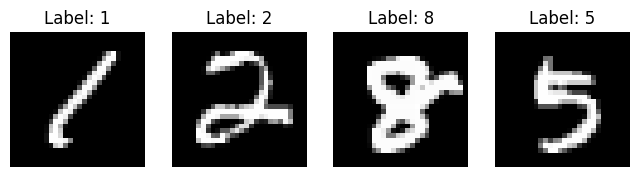

In [3]:
examples = iter(train_loader)
images, labels = next(examples)

plt.figure(figsize=(8, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i][0], cmap="gray")
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

## 6. Understanding Shape Flow in CNNs

The most common source of runtime errors in PyTorch is a **shape mismatch**, particularly at the transition between convolutional layers and fully connected (Linear) layers. To debug effectively, you must understand how each operation transforms the 4D input tensor: `(Batch Size, Channels, Height, Width)`.

### The Shape Transformation Formula

For any convolutional layer, the output spatial dimension (O) is calculated based on the input size (W), kernel size (K), padding (P), and stride (S):

O = [(W - K + 2P) / S] + 1


**Shape Flow for MNIST (28x28 images):**

1. **Input:** `(batch_size, 1, 28, 28)` — MNIST is grayscale, so it has only **1 channel**.
2. **Conv2d(1 -> 2, kernel=3, padding=1):** Calculation: [(28 - 3 + 2*1) / 1] + 1 = 28

* The spatial size stays the same because `padding=1` compensates for the `3x3` kernel.
* **Output:** `(batch_size, 2, 28, 28)`.


3. **MaxPool2d(kernel=2, stride=2):** Pooling layers divide the height and width by the stride.
* Calculation: 28 / 2 = 14
* **Output:** `(batch_size, 2, 14, 14)`.


4. **Flatten:** This collapses the spatial dimensions and channels into a single vector per image.
* Calculation: 2 * 14 * 14 = 392
* **Output:** `(batch_size, 392)`.


5. **Linear(392 -> 8):** A fully connected hidden layer. This is often where "Size Mismatch" errors occur if the input features (392) don't match the Flatten output.

* **Output:** `(batch_size, 8)`.

6. **Linear(8 -> 10):** Final output producing "logits" for each of the **10 classes** (digits 0-9).

* **Output:** `(batch_size, 10)`.



## 7. Defining a Tiny CNN

We will implement a minimal architecture called `TinyMNISTNet`. We keep the number of channels very low (only 2) to make it easier to visualize the weight matrices and understand how features are extracted.

In PyTorch, we define the layers in `__init__` and the data flow in the `forward` method.

In [4]:
class TinyMNISTNet(nn.Module):
    def __init__(self):
        super().__init__()

        # 1. Feature Extraction: Extracts spatial patterns from the image
        self.features = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=3, padding=1), # 1 input channel -> 2 feature maps
            nn.ReLU(),                                 # Non-linearity
            nn.MaxPool2d(2),                           # Halves resolution: 28x28 -> 14x14
        )

        # 2. Classification: Maps extracted features to class scores
        self.classifier = nn.Sequential(
            nn.Flatten(),                              # Converts 3D maps to a 1D vector (392 elements)
            nn.Linear(2 * 14 * 14, 8),                 # Compressed hidden layer
            nn.ReLU(),
            nn.Linear(8, 10)                           # Final layer: 10 outputs (one per digit)
        )

    def forward(self, x):
        # Data flows through features first, then the classifier
        x = self.features(x)
        x = self.classifier(x)
        return x


## 8. Shape Debugging

This utility function allows you to identify exactly where a tensor's shape might be deviating from your expectations.

In [5]:
def debug_forward_pass(model, input_shape=(1, 1, 28, 28)):
    print("=== Debugging Forward Pass ===")


    # Create a dummy 'image' with the expected input dimensions
    # (Batch Size, Channels, Height, Width)
    x = torch.randn(input_shape)
    print(f"Initial Input: {list(x.shape)}")

    # We iterate through the main components
    # Note: Named_children only shows top-level attributes
    for name, block in model.named_children():
        try:
            x = block(x)
            print(f"After {name:10}: {list(x.shape)}")
        except Exception as e:
            print(f"Error in block '{name}': {e}")
            return

    print(f"\nFinal Prediction Shape: {list(x.shape)}")

# Usage
model = TinyMNISTNet()
debug_forward_pass(model)

=== Debugging Forward Pass ===
Initial Input: [1, 1, 28, 28]
After features  : [1, 2, 14, 14]
After classifier: [1, 10]

Final Prediction Shape: [1, 10]


## 9. The ML Debugging Checklist

When your model performs poorly or crashes, follow this sequence:


### Data & Inputs

* **Normalization Check:** Ensure pixels are scaled (e.g., mean 0.1307, std 0.3081). Raw 0-255 values cause unstable gradients.
* **Label Integrity:** Verify that labels correctly map to images. Shuffled targets make the model learn "noise."
* **Class Balance:** Check if one class dominates. Imbalance leads to a model that only predicts the majority class.

### Architecture

* **Shape Flow Trace:** Ensure the output of the last Conv layer matches the input of the first Linear layer.
* **The "Overfit Single Batch" Test:** Try to reach 100% accuracy on 5 images. If this fails, your loss function or training loop logic is broken.


### Optimization

* **Learning Rate (LR) :**  **Too High:** Loss "explodes," bounces wildly, or results in `NaN`.**Too Low:** Loss remains perfectly flat for many epochs.

* Ensure gradients aren't vanishing (becoming too small) in early layers.



## 10. Training with an Intentional Bug

We will now intentionally use an excessively high learning rate to observe the failure.

In [6]:
model = TinyMNISTNet()
criterion = nn.CrossEntropyLoss()
# INTENTIONAL BUG: Learning rate set to 1.0 (normally 0.001)
optimizer = optim.Adam(model.parameters(), lr=1.0)

def train(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    return total_loss / len(loader), correct / total

print("Starting training with high Learning Rate...")
for epoch in range(3):
    loss, acc = train(model, train_loader, optimizer)
    print(f"Epoch {epoch}: Loss={loss:.4f}, Acc={acc:.4f}")

Starting training with high Learning Rate...
Epoch 0: Loss=6.8173, Acc=0.1017
Epoch 1: Loss=2.3723, Acc=0.1003
Epoch 2: Loss=2.3724, Acc=0.1027


### Why the Model Failed

The training logs show the model is **stagnant**, not learning. Even though the loss dropped initially, it settled at a "random guess" baseline.

* **Accuracy stuck at ~10%:** In a 10-class dataset like MNIST, 10% is the result of random guessing.
* A cross-entropy loss of roughly **2.3** (−ln(0.1)) is the mathematical signature of a model that is completely uncertain, assigning an equal 10% probability to every digit.
* The learning rate is so high that the optimizer "jumps" across the loss landscape, overshooting the optimal solution and landing on a flat plateau where it can no longer find its way down.


## 11. Gradient Diagnostic
We have adjusted the learning rate to **0.001** to ensure stable optimization. Before proceeding to full-scale training, we perform a **Gradient Inspection** to verify the integrity of the backpropagation signal.


The **magnitude (norm)** of the gradients represents the strength of the update signal. Monitoring this helps identify numerical instability early:

* **Optimal Flow (0.01 – 1.0):** The signal is stable. Weights will update at a controlled pace, allowing for smooth convergence.
* **Vanishing Gradients (< 1e-6):** The signal attenuates as it moves backward. This often occurs in deep networks, leaving early layers "frozen" and incapable of learning.
* **Exploding Gradients (> 10.0):** The signal grows exponentially. This leads to massive weight updates that "overshoot" the loss minimum, often resulting in `NaN` values.



In [7]:
def inspect_gradients(model):

    print(f"{'Layer Name':<25} | {'Gradient Norm':<15}")
    print("-" * 45)

    for name, param in model.named_parameters():
        if param.grad is not None:
            # The 'norm' is the total magnitude of all updates for this layer
            norm = param.grad.norm().item()
            print(f"{name:<25} | {norm:.6f}")
        else:
            print(f"{name:<25} | No Gradient (Check your code!)")

# Reset the model to clear the weights from before
model = TinyMNISTNet()

optimizer = optim.Adam(model.parameters(), lr=0.001)
# Clear any old gradients
optimizer.zero_grad()

data, target = next(iter(train_loader))
output = model(data)
loss = criterion(output, target)

# Backward pass: This calculates the gradients
loss.backward()
inspect_gradients(model)


Layer Name                | Gradient Norm  
---------------------------------------------
features.0.weight         | 0.055391
features.0.bias           | 0.015171
classifier.1.weight       | 0.418048
classifier.1.bias         | 0.049468
classifier.3.weight       | 0.039150
classifier.3.bias         | 0.100659



## 12. Exercise: Data Corruption (Label Shuffling)

A model may appear to be "learning" (loss goes down) but fail validation if the evaluation data is corrupted.

Your **Training Accuracy** will increase because the model is learning from correct data. However, your **Test Accuracy** will plummet to roughly **10%** (random chance).
If you see a massive gap between Train and Test performance, it usually means one of two things:
1. **Overfitting:** The model is memorizing the training data.
2. **Data Corruption:** The test set is broken, mislabeled, or follows a completely different distribution.




In [8]:
def corrupt_labels(dataset, seed=42):
    """
    Randomly shuffles the labels of a dataset while keeping the images intact.
    This simulates a broken data pipeline or mislabeled 'ground truth'.
    """
    np.random.seed(seed)
    # Convert targets to a numpy array, shuffle them, and put them back
    shuffled_targets = np.random.permutation(dataset.targets.numpy())
    dataset.targets = torch.tensor(shuffled_targets)

# We corrupt ONLY the test set to see the impact on evaluation
corrupt_labels(test_dataset)

def evaluate(model, loader):
    """Standard evaluation loop to calculate accuracy."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad(): # Disable gradient tracking for speed and memory efficiency
        for data, target in loader:
            output = model(data)
            _, predicted = torch.max(output, 1) # Get the index of the highest score
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

# Train normally on GOOD data, but evaluate on CORRUPTED data
print("Training on valid data...")
for epoch in range(2):
    loss, acc = train(model, train_loader, optimizer)
    print(f"Epoch {epoch}: Train Acc={acc:.4f}")

# Observe the 'Evaluation Gap'
test_acc = evaluate(model, test_loader)
print(f"\n[!] Test Accuracy on Corrupted Labels: {test_acc:.4f}")


Training on valid data...
Epoch 0: Train Acc=0.7346
Epoch 1: Train Acc=0.8896

[!] Test Accuracy on Corrupted Labels: 0.1020




## 13. The "Overfit 10 Samples" Debugging Technique

If you are unsure if your architecture is capable of learning, try to train it on a tiny batch. If it cannot reach 100% accuracy on 10 images, there is a fundamental bug in your code.




In [9]:
# Create a 10-sample "mini-world"
small_data, small_targets = next(iter(train_loader))
small_data, small_targets = small_data[:10], small_targets[:10]

model_test = TinyMNISTNet()
optimizer_test = optim.Adam(model_test.parameters(), lr=0.01) # Higher LR to force memorization

print("Attempting to overfit 10 samples...")
for epoch in range(50):
    optimizer_test.zero_grad()
    output = model_test(small_data)
    loss = criterion(output, small_targets)
    loss.backward()
    optimizer_test.step()

    if (epoch + 1) % 10 == 0:
        _, predicted = torch.max(output, 1)
        acc = (predicted == small_targets).sum().item() / 10
        print(f"Epoch {epoch+1:2}: Loss={loss.item():.4f}, Acc={acc:.2f}")

Attempting to overfit 10 samples...
Epoch 10: Loss=0.7232, Acc=0.90
Epoch 20: Loss=0.2113, Acc=1.00
Epoch 30: Loss=0.0353, Acc=1.00
Epoch 40: Loss=0.0075, Acc=1.00
Epoch 50: Loss=0.0027, Acc=1.00



## 14. Advanced Challenge: Designing a High-Accuracy CNN

To reach over 98% accuracy, a network needs more capacity.

**Recommended Design:**

* **Block 1:** Conv(1 -> 8), ReLU, MaxPool
* **Block 2:** Conv(8 -> 16), ReLU, MaxPool
* **Final Spatial Size:** After two MaxPool layers, a 28x28 image becomes 7x7.
* **Flatten Size:** The input to your first Linear layer must be 16×7×7=784.


In [10]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.classifier(self.features(x))



In [11]:
# Reload the test dataset to remove the corruption from Section 12
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

print("Test labels restored. Ready for final evaluation.")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(f"Training ImprovedCNN on {device}...")
for epoch in range(5):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # Move to GPU

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Evaluation Phase
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) # Move to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}, "
          f"Train Acc={correct/total:.4f}, Test Acc={test_correct/test_total:.4f}")


Test labels restored. Ready for final evaluation.
Training ImprovedCNN on cuda...
Epoch 1: Loss=0.2333, Train Acc=0.9300, Test Acc=0.9740
Epoch 2: Loss=0.0736, Train Acc=0.9770, Test Acc=0.9776
Epoch 3: Loss=0.0530, Train Acc=0.9839, Test Acc=0.9831
Epoch 4: Loss=0.0415, Train Acc=0.9871, Test Acc=0.9872
Epoch 5: Loss=0.0347, Train Acc=0.9892, Test Acc=0.9882


## 15. Advanced Diagnostic Visualizations

When a model reaches high accuracy, a simple "Loss" value no longer provides enough information to improve the model further and we might want to look inside the "Black Box" using advanced visualizations.









### The Confusion Matrix

A Confusion Matrix compares the model's predictions against the actual labels in a grid format.

* Look for high numbers outside the diagonal line. For example, if you see a high count where "Actual 4" meets "Predicted 9," your model is struggling with vertical strokes.
* You may need more convolutional filters or specific data augmentation (like slight rotations) to help the model tell these shapes apart.

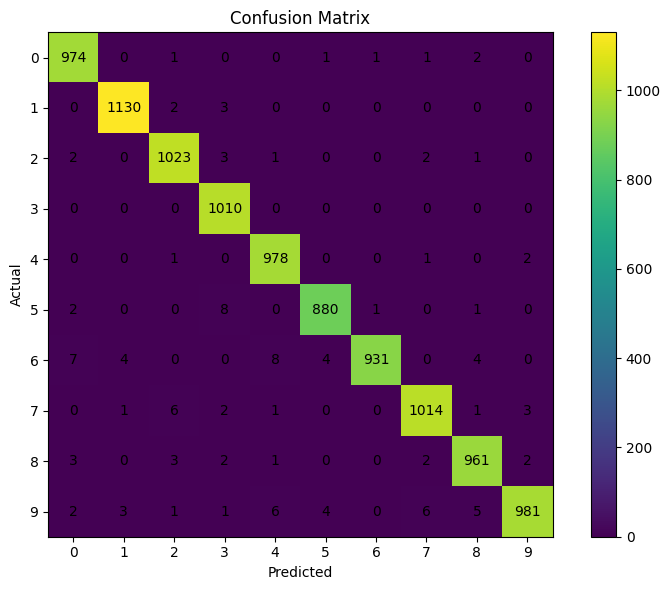

In [13]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm)
    plt.colorbar()

    # Add numbers inside cells
    num_classes = cm.shape[0]
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, cm[i, j],
                     ha="center",
                     va="center")

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(np.arange(num_classes))
    plt.yticks(np.arange(num_classes))
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(model, test_loader, device)


### Inspecting Misclassifications

This tool extracts the specific images where the model was wrong and displays them with their incorrect labels.

* **How to use it for debugging:** Check if the errors are "reasonable." If a human can't tell if the digit is a 5 or a 6 because the handwriting is poor, the model has likely reached its maximum potential.
* If the images look perfectly clear to you but the model fails, the issue is architectural—your network might be too "shallow" to perceive those features.




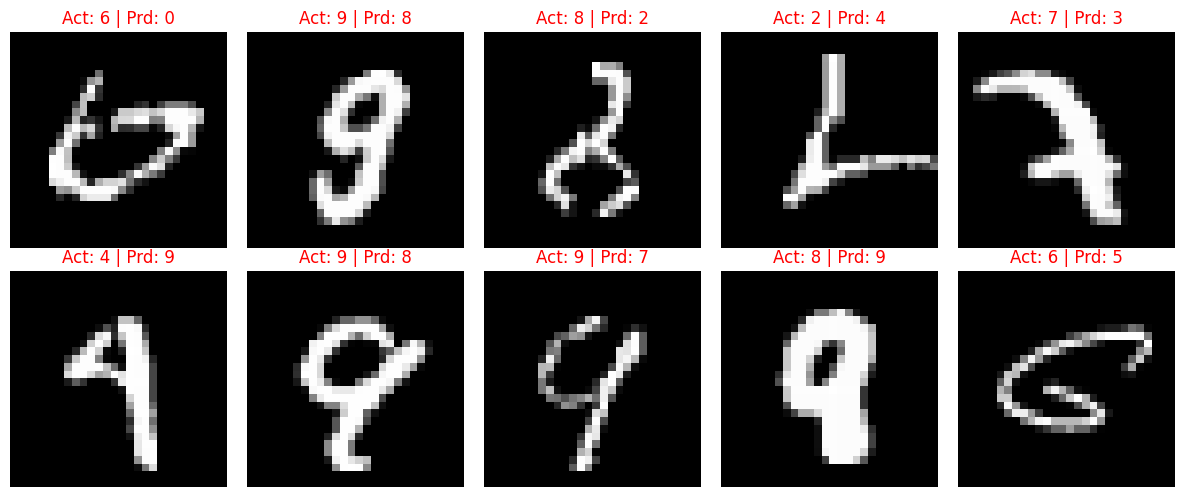

In [14]:
def plot_errors(model, loader):
    model.eval()
    images, labels, preds = [], [], []
    with torch.no_grad():
        for img, lbl in loader:
            img, lbl = img.to(device), lbl.to(device)
            output = model(img)
            _, prd = torch.max(output, 1)

            # Find indices where prediction is wrong
            mask = prd != lbl
            images.extend(img[mask].cpu())
            labels.extend(lbl[mask].cpu())
            preds.extend(prd[mask].cpu())
            if len(images) > 10: break # Just get a few

    plt.figure(figsize=(12, 5))
    for i in range(min(10, len(images))):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Act: {labels[i]} | Prd: {preds[i]}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_errors(model, test_loader)

### Feature Map Visualization

Feature maps show us exactly what the convolutional filters are detecting in real-time.

* If the feature maps are mostly blank (black) or look like static noise, the model's filters haven't "activated."
*  This usually indicates a **Vanishing Gradient** or a **Dead ReLU** problem. You may need to check your weight initialization or add Batch Normalization(BatchNorm fixes this by normalizing the activations of a layer so they have a mean of 0 and a standard deviation of 1 for every mini-batch.).

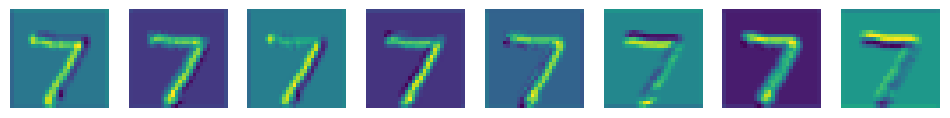

In [15]:
def visualize_features(model, image):
    model.eval()
    with torch.no_grad():
        # Pass the image through just the first conv layer
        feature_maps = model.features[0](image.to(device))

    plt.figure(figsize=(12, 4))
    for i in range(feature_maps.shape[1]): # Loop through filters
        plt.subplot(1, 8, i+1)
        plt.imshow(feature_maps[0, i].cpu(), cmap='viridis')
        plt.axis('off')
    plt.show()

# To call it using one image from the loader:
sample_img, _ = next(iter(test_loader))
visualize_features(model, sample_img[:1])